In [62]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [63]:
ds = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')

In [64]:
df = ds.drop(columns=['MidRate', 'Selling'])
df['Buying'] = df['Buying'].astype(str).str.replace(',', '').astype(float)

In [65]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.set_index('Date').sort_index()

In [66]:
df['Buying'] = df['Buying'].replace(0, np.nan)
df['Buying'] = df['Buying'].interpolate()

ADF Statistic: 1.0415
p-value: 0.9947
Critical Value 1%: -3.4319
Critical Value 5%: -2.8622
Critical Value 10%: -2.5671

After 1 differencing(s):
ADF Statistic: -11.2133
p-value: 0.0000

Number of differences (d) needed for stationarity: 1


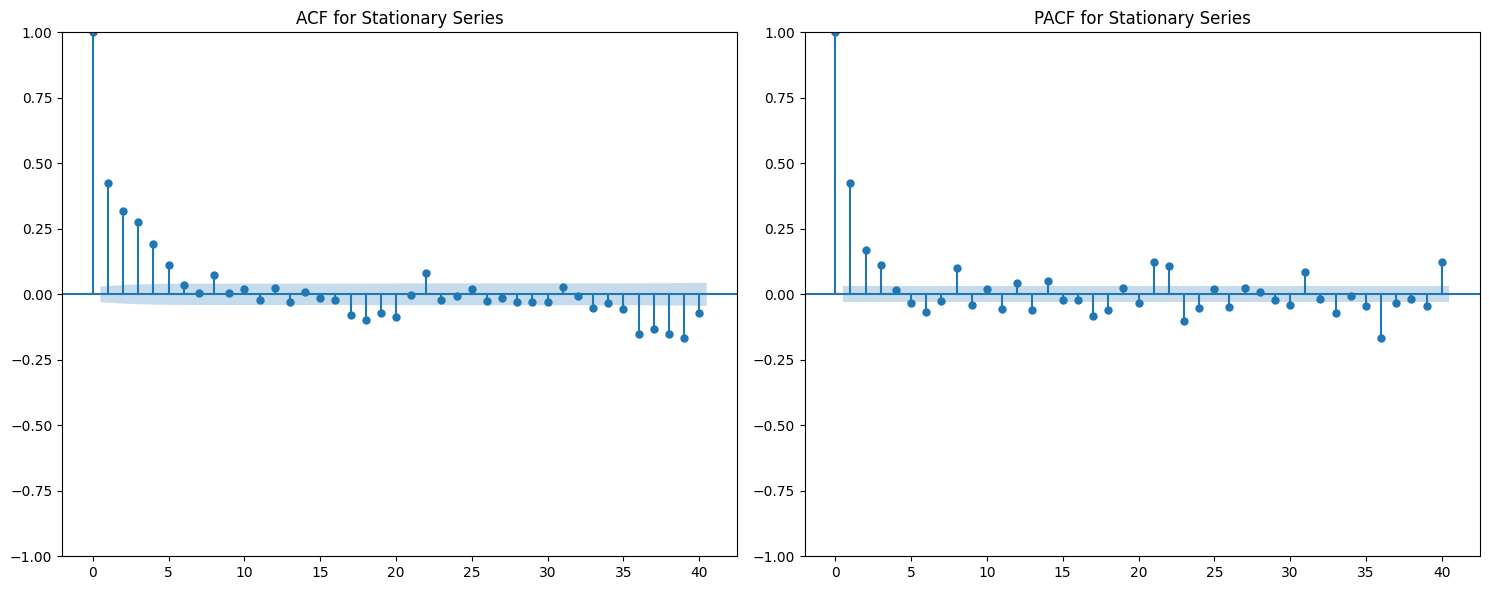

In [84]:
# 1. Extract the Buying price series
buying_series = df['Buying']

# 2. Test for stationarity using the Augmented Dickey-Fuller test
adf_result = adfuller(buying_series.dropna())
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value:.4f}')

# 3. If not stationary, difference the series until stationary
stationary_series = buying_series.copy()
d = 0
while adfuller(stationary_series.dropna())[1] > 0.05:
    stationary_series = stationary_series.diff().dropna()
    d += 1
    adf_test_post = adfuller(stationary_series)
    print(f'\nAfter {d} differencing(s):')
    print("ADF Statistic: {:.4f}".format(adf_test_post[0]))
    print("p-value: {:.4f}".format(adf_test_post[1]))

print(f"\nNumber of differences (d) needed for stationarity: {d}")

# 4. Plot ACF and PACF
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_acf(stationary_series, ax=plt.gca(), lags=40,
         title='ACF for Stationary Series')
plt.subplot(1, 2, 2)
plot_pacf(stationary_series, ax=plt.gca(), lags=40,
          method='ywm', title='PACF for Stationary Series')
plt.tight_layout()
plt.savefig('plots/arima/acf_pacf_plot.png')
plt.show()

In [68]:
# 5. Build ARIMA Model (choose p, d, q based on ACF/PACF or as example p=1, q=1)
p = 1
q = 1
arima_model = ARIMA(buying_series, order=(p, d, q))
arima_result = arima_model.fit()

In [69]:
# 6. Model Summary
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Buying   No. Observations:                 4217
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6802.302
Date:                Thu, 16 Oct 2025   AIC                         -13598.604
Time:                        12:43:29   BIC                         -13579.564
Sample:                             0   HQIC                        -13591.872
                               - 4217                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7588      0.003    232.171      0.000       0.752       0.765
ma.L1         -0.4196      0.005    -89.440      0.000      -0.429      -0.410
sigma2         0.0023   4.23e-06    549.757      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):          15422943.55
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):             351.27   Skew:                             6.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       299.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
# Predict for the last 20% of the data using integer indexes
number_of_observations = len(buying_series)
start_index = int(number_of_observations * 0.8)
end_index = number_of_observations - 1

In [71]:
# predictions
arima_predictions = arima_result.predict(start=start_index, end=end_index)

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

In [73]:
arima_mae = mean_absolute_error(
    buying_series[-len(arima_predictions):], arima_predictions)
arima_mse = mean_squared_error(
    buying_series[-len(arima_predictions):], arima_predictions)
# arima_rmse = np.sqrt(arima_mse)
arima_rmse = root_mean_squared_error(
    buying_series[-len(arima_predictions):], arima_predictions)
arima_r2 = r2_score(
    buying_series[-len(arima_predictions):], arima_predictions)

results_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'MAE': [arima_mae],
    'MSE': [arima_mse],
    'RMSE': [arima_rmse],
    'R2': [arima_r2]
})

In [74]:
results_df

,Model,MAE,MSE,RMSE,R2
0,ARIMA,0.030525,0.011232,0.105981,0.998888


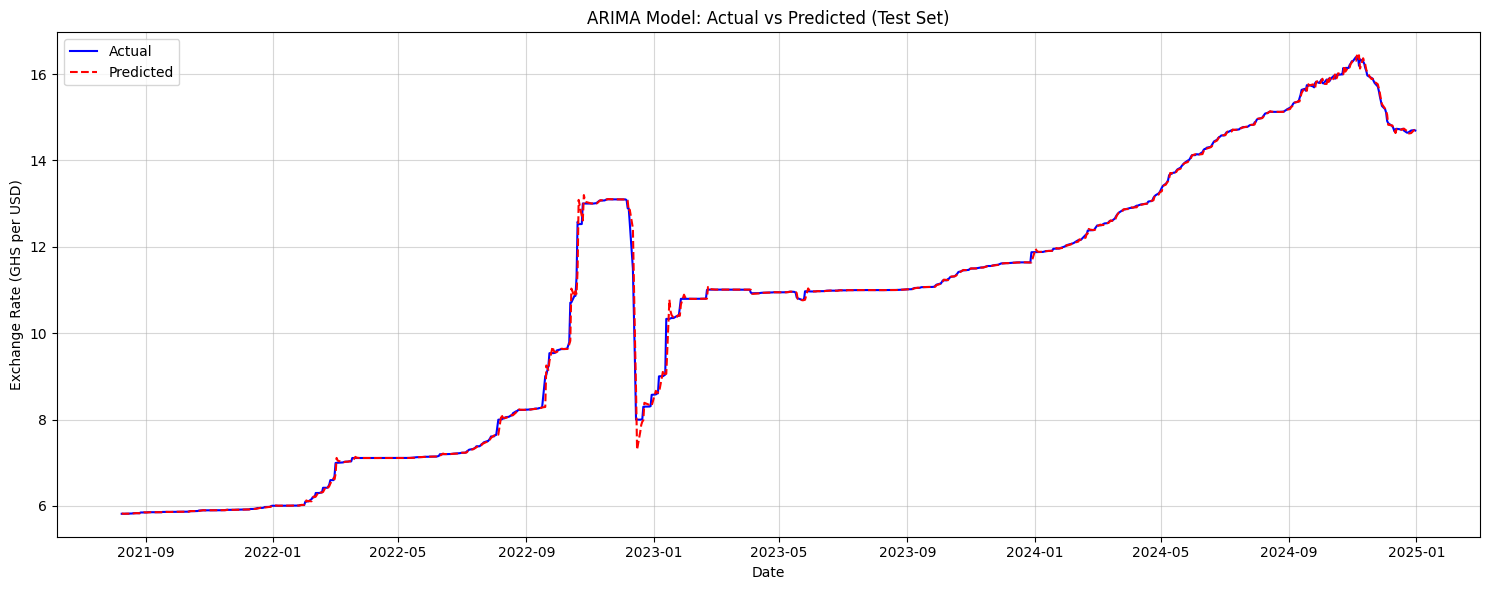

In [85]:
# Plot actual vs predicted values for ARIMA model predictions on test set
plt.figure(figsize=(15, 6))

# Actual values (last 20%)
actual = buying_series[-len(arima_predictions):]

# Predicted values
predicted = arima_predictions

# Align index
plot_index = actual.index

plt.plot(plot_index, actual, label='Actual', color='blue')
plt.plot(plot_index, predicted, label='Predicted', linestyle='--', color='red')
plt.title('ARIMA Model: Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (GHS per USD)')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('plots/arima/arima_actual_predicted.png')
plt.show()

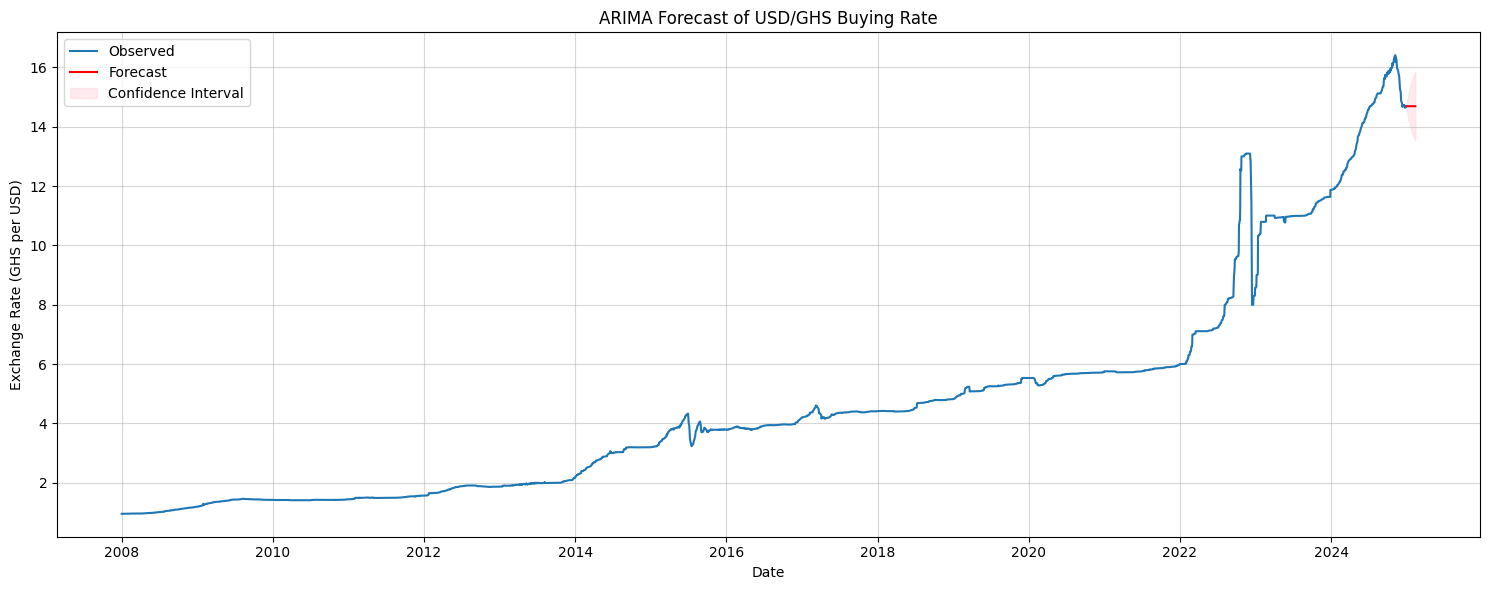

In [86]:
# 7. Forecast next 30 days (or periods)
forecast_periods = 30
forecast = arima_result.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(
    # Next business days
    df.index[-1], periods=forecast_periods+1, freq='B')[1:]

forecast_series = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(15, 6))
plt.plot(df.index, buying_series, label='Observed')
plt.plot(forecast_index, forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast of USD/GHS Buying Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (GHS per USD)')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('plots/arima/forecasted_order_1_1_1_observed_vs_forecasted_ci.png')
plt.show()

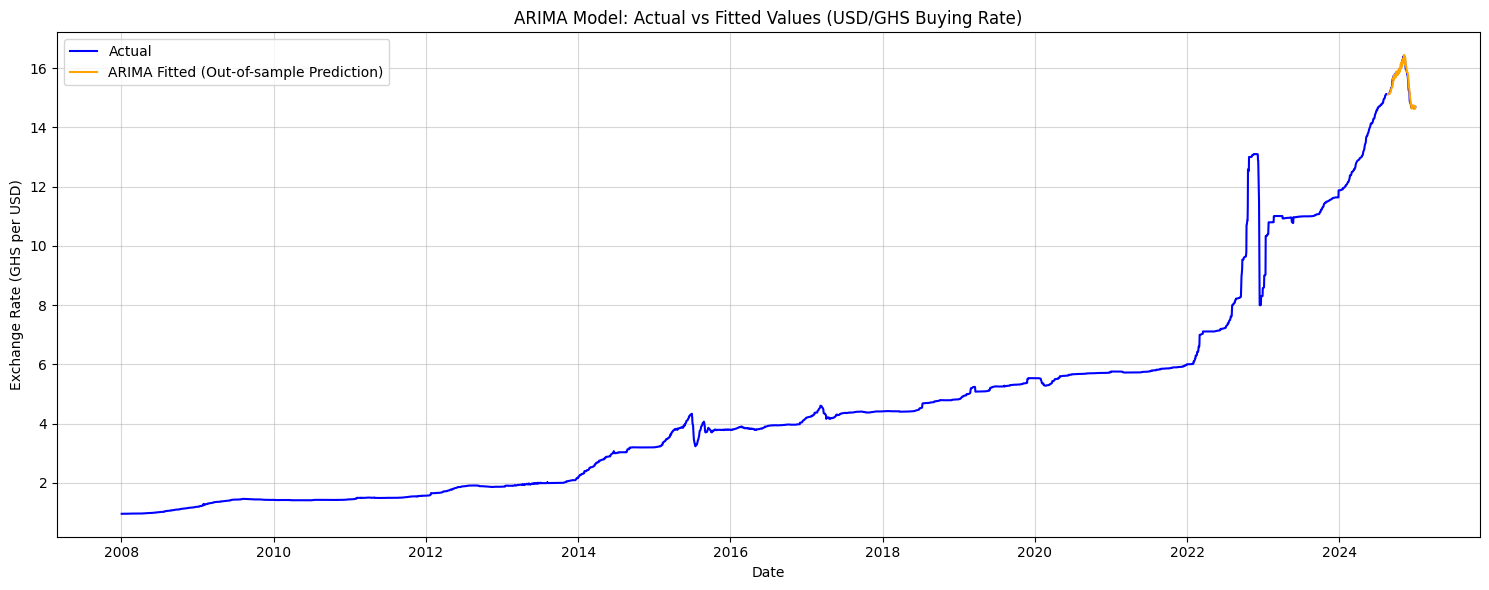

In [87]:
# Plot actual vs predicted values for ARIMA model
# Get out-of-sample predictions (for example, the last 90 data points)
fitted_values = arima_result.predict(
    start=len(stationary_series) - 90, end=len(stationary_series) - 1)

plt.figure(figsize=(15, 6))
plt.plot(df.index, buying_series, label='Actual', color='blue')
# Align fitted_values to the correct index so their lengths match for plotting
plot_index = df.index[-len(fitted_values):]
plt.plot(plot_index, fitted_values,
         label='ARIMA Fitted (Out-of-sample Prediction)', color='orange')
plt.title('ARIMA Model: Actual vs Fitted Values (USD/GHS Buying Rate)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (GHS per USD)')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('plots/arima/arima_order_1_1_1_actual_fitted_values_out_of_sample.png')
plt.show()

In [88]:
import pmdarima as pm

# Run auto_arima on the buying series (ignore missing values)
auto_arima_model = pm.auto_arima(
    buying_series,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    seasonal=False,  # If you want seasonal set to True and specify m
    d=None,          # Let auto_arima select the order of differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("Best ARIMA order selected by auto_arima:", auto_arima_model.order)
print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12602.878, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13441.164, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13200.841, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12589.697, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13560.243, Time=0.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-13612.536, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-13611.115, Time=2.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13598.438, Time=1.79 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-13611.076, Time=0.71 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 7.743 seconds
Best ARIMA order selected by auto_arima: (3, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4217
Model:               SARIMAX(3, 1, 0)   Log Likelihood     

In [89]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model using the best order found by auto_arima
best_order = auto_arima_model.order
arima_best = ARIMA(buying_series, order=best_order)
arima_best_result = arima_best.fit()

# Get in-sample predictions (one-step-ahead)
predictions = arima_best_result.predict(start=buying_series.index[0], end=buying_series.index[-1])

In [90]:
# Compute metrics
mae = mean_absolute_error(buying_series, predictions)
mse = mean_squared_error(buying_series, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(buying_series, predictions)

# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R2': [r2]
})

metrics_df

,Model,MAE,MSE,RMSE,R2
0,ARIMA,0.009209,0.002531,0.050306,0.999803


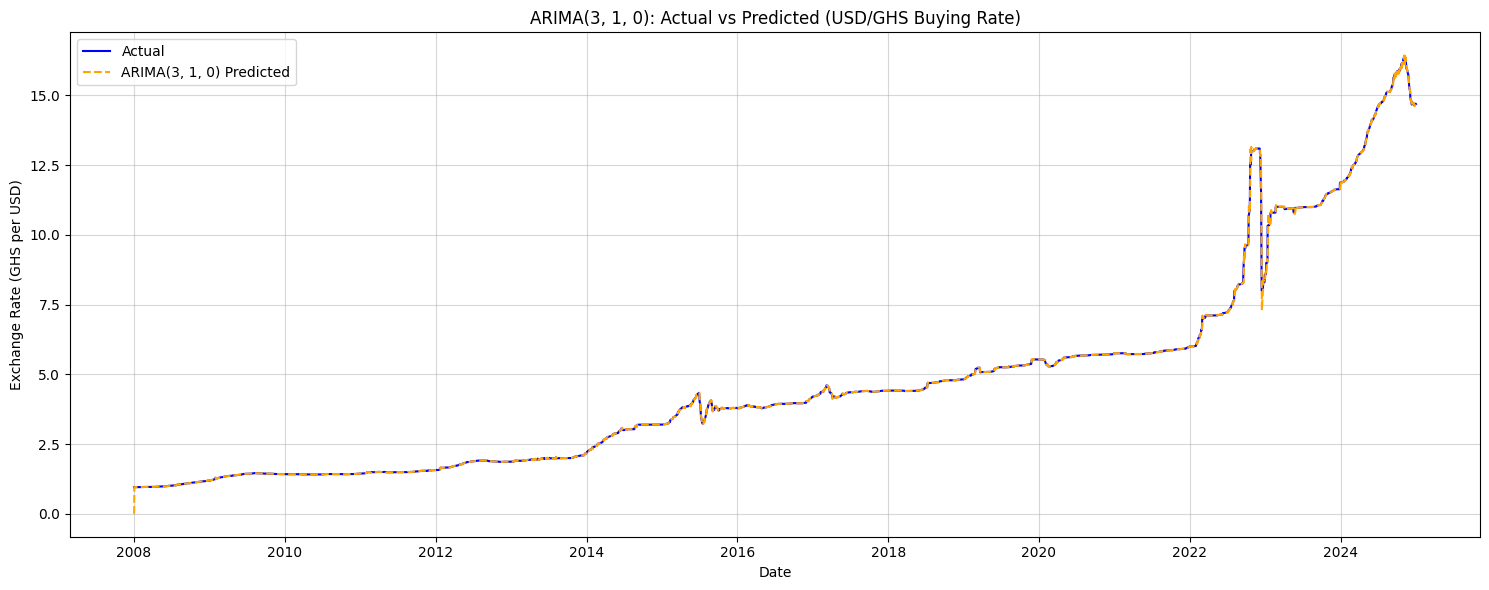

In [91]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(buying_series.index, buying_series, label='Actual', color='blue')
plt.plot(predictions.index, predictions,
         label=f'ARIMA{best_order} Predicted', linestyle='--', color='orange')
plt.title(f'ARIMA{best_order}: Actual vs Predicted (USD/GHS Buying Rate)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (GHS per USD)')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('plots/arima/auto_arima_actual_vs_predicted_best_order.png')
plt.show()